#### **Principal Component Analysis (PCA)**

PCA es una técnica que permite reducir el número de variables o factores de un conjunto de datos con el objetivo de facilitar el análisis. PCA puede utilizarse en los escenarios siguientes:

* **Cuando tenemos demasiadas variables que analizar.** Imagínate tener un conjunto con 100+ variables con miles y miles de filas de información. Tardaríamos mucho procesando todo esos datos, así que necesitamos una forma de simplificar nuestro conjunto de datos.
* **Cuando tenemos variables correlacionadas**. Supongamos que queremos predecir el salario medio de los estudiantes de MNA en función de dos variables en nuestro conjunto de datos, tiempo laboral y edad. También supongamos que estas dos variables tienen una correlación de 0.9 (recuerda que la correlación va de -1 a 1). 
  
    Esto significa que a medida que aumenta nuestra edad, aumenta nuestro tiempo laboral. Por tanto, la información contenida en una variable (por ejm edad) es prácticamente la misma que en la variable "tiempo laboral" para efectos de predecir el salario medio. Esta "duplicidad de información", por llamarle así, podría afectar el desempeño de nuestro algoritmo.

    PCA nos permite crear componentes que no estén correlacionados entre si para precisamente evitar afectar el desempeño del modelo.

Comencemos viendo un ejemplo.

In [1]:
import pandas as pd
import numpy as np

cereals = 'https://raw.githubusercontent.com/tec03/Datasets/main/datasets/Cereals.csv'

In [2]:
cereals_df = pd.read_csv(cereals)
df = cereals_df.copy() #Copiemos el dataframe con los datos originales por si metemos la pata más adelante. Siempre es bueno tener su backup.
df.dropna(axis = 0, inplace=True) # Nos llevamos todos los valores vacíos. De lo contrario, nos va a dar un error cuando apliquemos el PCA
df

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100%_Bran,N,C,70,4,1,130,10.0,5.0,6.0,280.0,25,3,1.0,0.33,68.402973
1,100%_Natural_Bran,Q,C,120,3,5,15,2.0,8.0,8.0,135.0,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5.0,320.0,25,3,1.0,0.33,59.425505
3,All-Bran_with_Extra_Fiber,K,C,50,4,0,140,14.0,8.0,0.0,330.0,25,3,1.0,0.50,93.704912
5,Apple_Cinnamon_Cheerios,G,C,110,2,2,180,1.5,10.5,10.0,70.0,25,1,1.0,0.75,29.509541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Triples,G,C,110,2,1,250,0.0,21.0,3.0,60.0,25,3,1.0,0.75,39.106174
73,Trix,G,C,110,1,1,140,0.0,13.0,12.0,25.0,25,2,1.0,1.00,27.753301
74,Wheat_Chex,R,C,100,3,1,230,3.0,17.0,3.0,115.0,25,1,1.0,0.67,49.787445
75,Wheaties,G,C,100,3,1,200,3.0,17.0,3.0,110.0,25,1,1.0,1.00,51.592193


Ya deberías estar familiarizado con lo que hicimos en el paso anterior (es decir, ya tienes todo un badge de Python). Así que comencemos explorando nuestro conjunto de datos.

Primero, nos interesa saber cuáles son las variables numéricas (también llamadas continuas) de nuestro conjunto de datos. Esto porque la técnica PCA solo trabaja con variables continuas y no categóricas.

Recordando, las variables continuas o numéricas son aquellas que cuantifican algo (por ej. edad, peso, salario, etc). Las variables categóricas solo representan una cateogoría (color, ciudad, las escalas de una encuesta donde 1 = malo, 2 = regular, etc). Normalmente las variables categóricas se representan como texto en el conjunto de datos.

Bien, ahora exploremos los datos que importamos.

In [3]:
df.info() #info es un método que te dice cuantas filas de datos hay, cuantas columnas y el tipo de dato de cada columna.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 76
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      74 non-null     object 
 1   mfr       74 non-null     object 
 2   type      74 non-null     object 
 3   calories  74 non-null     int64  
 4   protein   74 non-null     int64  
 5   fat       74 non-null     int64  
 6   sodium    74 non-null     int64  
 7   fiber     74 non-null     float64
 8   carbo     74 non-null     float64
 9   sugars    74 non-null     float64
 10  potass    74 non-null     float64
 11  vitamins  74 non-null     int64  
 12  shelf     74 non-null     int64  
 13  weight    74 non-null     float64
 14  cups      74 non-null     float64
 15  rating    74 non-null     float64
dtypes: float64(7), int64(6), object(3)
memory usage: 9.8+ KB


En este conjunto de datos tenemos un total de 77 filas de información (entradas). También vemos que las columnas: "name", "mfr" y "type" son del tipo categóricas y pandas las lee como texto (object).

Las demás columnas son variables numéricas, donde algunas son del tipo float (tiene punto decimal) y otras del tipo int (son enteros. No tienen punto decimal).

Según el resumen resentado abajo, tenemos 7 variables float, 6 variables int y 3 del tipo object. Eso significa que hay un total de 13 variables numéricas.

Ahora veamos la correlación entre las variables numéricas, pero primero vamos a extraer solo las columnas con variables numéricas.

In [4]:

#Este código lo le dice a pandas es que me de todas las filas [:,] pero para las columnas que están a partir del índice 3 (calorías) [:,3:]
#Recuerda que python cuenta desde cero. Aunque calorías es la columna 4, realmente se encuentra en la posición 3

df_num = df.iloc[:,3:]
df_num.head()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,70,4,1,130,10.0,5.0,6.0,280.0,25,3,1.0,0.33,68.402973
1,120,3,5,15,2.0,8.0,8.0,135.0,0,3,1.0,1.00,33.983679
2,70,4,1,260,9.0,7.0,5.0,320.0,25,3,1.0,0.33,59.425505
3,50,4,0,140,14.0,8.0,0.0,330.0,25,3,1.0,0.50,93.704912
5,110,2,2,180,1.5,10.5,10.0,70.0,25,1,1.0,0.75,29.509541


Ahora sí, busquemos la correlación entre las variables.

In [5]:
df_num.corr()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
calories,1.000000,0.033992,0.507373,0.296247,-0.295212,0.270606,0.569121,-0.071361,0.259846,0.089243,0.696452,0.089196,-0.693785
protein,0.033992,1.000000,0.202353,0.011559,0.514006,-0.036743,-0.286584,0.578743,0.054800,0.195635,0.230671,-0.242099,0.467162
fat,0.507373,0.202353,1.000000,0.000822,0.014036,-0.284934,0.287152,0.199637,-0.030514,0.277980,0.221714,-0.157579,-0.405050
sodium,0.296247,0.011559,0.000822,1.000000,-0.070735,0.328409,0.037059,-0.039438,0.331576,-0.121897,0.312534,0.119584,-0.383012
fiber,-0.295212,0.514006,0.014036,-0.070735,1.000000,-0.379084,-0.150949,0.911504,-0.038717,0.313787,0.246292,-0.513697,0.603411
carbo,0.270606,-0.036743,-0.284934,0.328409,-0.379084,1.000000,-0.452069,-0.365003,0.253579,-0.188996,0.144805,0.358284,0.055941
sugars,0.569121,-0.286584,0.287152,0.037059,-0.150949,-0.452069,1.000000,0.001414,0.072954,0.061449,0.460547,-0.032436,-0.755955
potass,-0.071361,0.578743,0.199637,-0.039438,0.911504,-0.365003,0.001414,1.000000,-0.002636,0.394585,0.420562,-0.501688,0.415782
vitamins,0.259846,0.054800,-0.030514,0.331576,-0.038717,0.253579,0.072954,-0.002636,1.000000,0.284405,0.320435,0.133630,-0.214481
shelf,0.089243,0.195635,0.277980,-0.121897,0.313787,-0.188996,0.061449,0.394585,0.284405,1.000000,0.192843,-0.351034,0.051040


Ok ok ok.. ya se. La tabla está complicada de analizar. Pero por suerte, el poderoso Falcon nos enseñó una manera visual para interpretar la información anterior

<AxesSubplot: >

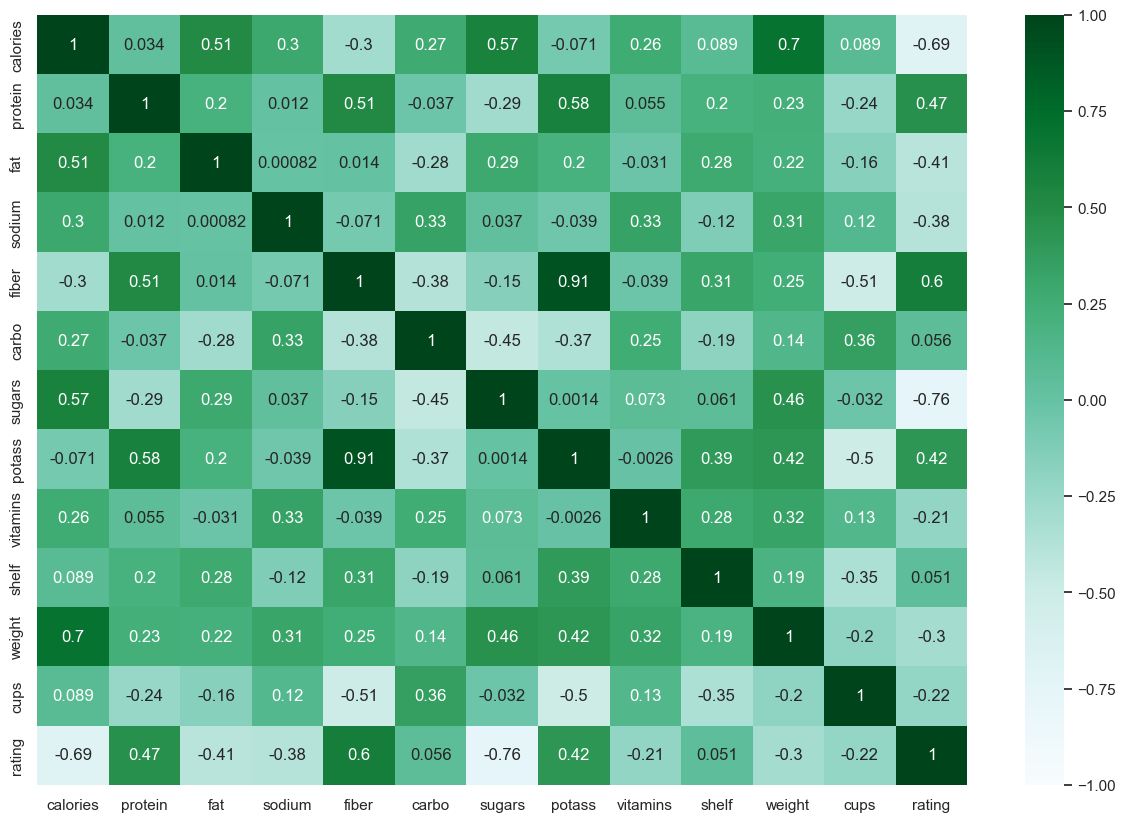

In [6]:
import seaborn as sns

corrs = df_num.corr()

sns.set(rc = {'figure.figsize':(15,10)})
sns.heatmap(corrs, vmin = -1, vmax = 1, cmap = "BuGn", annot= True)

De la tabla anterior podemos ver que las casillas con verde oscuro o de color blanco son las que están mayor correlacionadas. Mientras más oscuro es el verde, más estrecha es la correlación positiva (a medida que uno crece, la otra también lo hace). Mientras más blanca es la casilla, más estrecha es su correlación negativa (a medida que una crece, la otra disminuye). Cuando la correlación es cero (casilla con verde claro) significa que no hay correlación.

Dicho lo anterior, podemos ver algunas variables fuertemente correlacionadas de manera positiva (como potasio con fibra) y fuertemente correlacionadas de manera negativa (como azúcares y el rating).

Como comentamos más arriba, el hecho que estas variables estén correlacionadas significa para el modelo información repetida.

Ahora veamos las varianzas de algunas de las variables.

In [7]:
cols = ["calories", "sodium", "fiber"] #Aquí definimos la lista de variables que nos interesa analizar.

#Creamos un objeto que contiene los estadísticos que nos interesan y sus valores. 
# El [0:3] que ves es para decirle a pandas que solo me de los valores numéricos, sin el nombre de cada variable.
summary = {
    "Varianzas": df_num[cols].var()[0:3],
    "Valor Min": df_num[cols].min()[0:3],
    "Valor Max": df_num[cols].max()[0:3]
}

#Metemos todo en un dataframe para que se vea mejor.
#El transpose lo que hace es convertir las columnas en filas y viceversa.
pd.DataFrame(summary, index = cols).transpose()



,calories,sodium,fiber
Varianzas,393.780081,6850.837653,5.872825
Valor Min,50.000000,0.000000,0.000000
Valor Max,160.000000,320.000000,14.000000


De la tabla anterior observamos algo. Fíjate que el valor de la varianza para "sodium" es de 7,027, mientras que para las "calories" y "fiber" es de 379 y 5.68 respectivamente.

¿Qué nos dice la varianza?

Sugiero revisar el tutorial de "Introducción a la Estadística", pero en resumen, la varianza nos dice que tanta información hay en cada variable. En este caso, parecería que la variable "sodium" es la que contiene mayor información en comparación con "calories" y "fiber". Sin embargo, fíjate que el rango de "sodium" va de 0 a 320, mienttras que el rango de "calories" y "fiber" van desde 50 a 160 y 0 a 14 respectivamente.

Esto significa que el valor de la varianza se ve afectada seriamente por la magnitud de las variables.]

El problema con esto es que PCA utiliza las varianzas para hacer su magia y podría pensar que si "sodium" tiene el valor más alto de la varianza que las otras dos, pues que esta variable es más importante que las demás, cuando no necesariamente sea así, ya que su valor es alto por la unidad de medición más que por su importancia para el conjunto de datos.

Podemos ver más claramente lo anterior si buscamos el % total de las varianzas que representan cada una de estas variables:

In [8]:
#Buscamos la varianza total de todas las variables
t = df_num.var().sum()

#Calculamos la varianza para cada variable que estamos estudiando
var_cal = df_num.calories.var()
var_sod = df_num.sodium.var()
var_fib = df_num.fiber.var()

#Sacamos el % que representa la varianza de cada variable respecto al total.
print('Varianza Total \t\t:',t.round(2) )
print('Varianza Calorías \t:', ((var_cal/t)*100).round(2),'%' )
print('Varianza Sodio \t\t:', ((var_sod/t)*100).round(2),'%' )
print('Varianza Fibras \t:', ((var_fib/t)*100).round(2),'%' )

Varianza Total 		: 13005.35
Varianza Calorías 	: 3.03 %
Varianza Sodio 		: 52.68 %
Varianza Fibras 	: 0.05 %


Mira como el sodio representa el 53% del total de la varianza. Como dijimos anteriormente, esto no necesariamente significa que el sodio sea una característica más importante que las otras dos. Simplemente su % es más alto porque su rango de valores es mucho más alto.

Para poder resolver este problema, debemos entonces escalar los datos. Esto nos va a permitir que todos los datos estén en una misma escala y así evitar que se vea afectado el resultado del PCA.

Para escalar los datos, vamos a usar el StandardScaler de la librería scikit. Básicamente el StandardScaler lo que hace es aplicar la siguiente fórmula para cada columna:

$X_{nuevo}$ = $\frac{X - \mu}{\sigma}$ donde:

* $\mu$ = la media de la columna
* $\sigma$ = la DE de la columna
* X = Cada valor de la columna

Pongamos lo anterior en práctica.

In [9]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
scaled = scaler.fit_transform(df_num)

scaled

array([[-1.87865227,  1.3911796 ,  0.        , -0.39369182,  3.25070642,
        -2.51720557, -0.25594026,  2.57800107, -0.18308346,  0.94840141,
        -0.20220332, -2.09989497,  1.86756537],
       [ 0.65821393,  0.45529514,  4.        , -1.79257173, -0.0729865 ,
        -1.74106718,  0.2060007 ,  0.51828763, -1.31209813,  0.94840141,
        -0.20220332,  0.76191901, -0.60179124],
       [-1.87865227,  1.3911796 ,  0.        ,  1.18765068,  2.8352448 ,
        -1.99977998, -0.48691074,  3.14619788, -0.18308346,  0.94840141,
        -0.20220332, -2.09989497,  1.22349144],
       [-2.89339875,  1.3911796 , -1.        , -0.27205009,  4.91255287,
        -1.74106718, -1.64176313,  3.28824708, -0.18308346,  0.94840141,
        -0.20220332, -1.37376306,  3.68281208],
       [ 0.15084069, -0.48058932,  1.        ,  0.21451684, -0.28071731,
        -1.0942852 ,  0.66794165, -0.40503219, -0.18308346, -1.47165737,
        -0.20220332, -0.30592203, -0.92278104],
       [ 0.15084069, -0.480589

Lo anterior nos dio un montón de números. Vamos a acomodarlos un poco para mejor lectura

In [10]:
scaled_df = pd.DataFrame(scaled, columns=df_num.columns)
scaled_df.head()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,-1.878652,1.391180,0.0,-0.393692,3.250706,-2.517206,-0.255940,2.578001,-0.183083,0.948401,-0.202203,-2.099895,1.867565
1,0.658214,0.455295,4.0,-1.792572,-0.072986,-1.741067,0.206001,0.518288,-1.312098,0.948401,-0.202203,0.761919,-0.601791
2,-1.878652,1.391180,0.0,1.187651,2.835245,-1.999780,-0.486911,3.146198,-0.183083,0.948401,-0.202203,-2.099895,1.223491
3,-2.893399,1.391180,-1.0,-0.272050,4.912553,-1.741067,-1.641763,3.288247,-0.183083,0.948401,-0.202203,-1.373763,3.682812
4,0.150841,-0.480589,1.0,0.214517,-0.280717,-1.094285,0.667942,-0.405032,-0.183083,-1.471657,-0.202203,-0.305922,-0.922781


Aaah, mucho mejor.

Mira como ahora los valores de cada columna están en una misma escala. De hecho, lo podemos confirmar repitiendo los pasos anterior para el nuevo conjunto de datos.

In [11]:
summary = {
    "Varianzas": scaled_df[cols].var()[0:3],
    "Valor Min": scaled_df[cols].min()[0:3],
    "Valor Max": scaled_df[cols].max()[0:3]
}

#recuerda que la variable cols la definimos más arriba.
pd.DataFrame(summary, index = cols).transpose()

,calories,sodium,fiber
Varianzas,1.013699,1.013699,1.013699
Valor Min,-2.893399,-1.975034,-0.903910
Valor Max,2.687707,1.917501,4.912553


Mira como están las escalas ahora. Mucho mejor.

¡Ahora si! Vamos a aplicar PCA.

In [12]:
from sklearn.decomposition import PCA


pcs = PCA()

#Nota: Recuerda limpiar los valores vacíos de tu conjunto de datos antes de aplicar este paso. De lo contrario, te va a dar un error.
pcs_t = pcs.fit_transform(scaled_df)
pcs_t



array([[ 5.74699468e+00, -1.18754493e+00, -9.83892817e-01,
         4.21067151e-01, -1.17648976e+00, -9.72465986e-01,
        -2.23205768e-01, -2.43515414e-01, -1.35079530e-01,
         4.94325242e-02,  2.50305180e-01,  1.07012325e-02,
         1.02214127e-08],
       [ 4.11657263e-01, -1.86931006e+00, -2.90141962e+00,
        -8.58534556e-01,  3.27153247e+00, -6.81940088e-01,
        -9.62610662e-01,  9.03571379e-01, -8.41989141e-01,
        -5.94657823e-01,  6.72479464e-02, -9.46915049e-02,
         1.65118898e-09],
       [ 5.16771991e+00, -1.50411125e+00, -1.02637140e-01,
         1.69396492e-01, -1.55967189e+00, -1.99680135e+00,
         4.15834246e-01,  1.86686561e-01,  1.40228216e-01,
         8.42623444e-02, -5.17210370e-01, -1.49849911e-02,
         1.47326434e-08],
       [ 7.85620202e+00,  2.41896474e-01,  6.76601318e-01,
         4.67310611e-01, -1.77033993e+00, -7.81377826e-01,
        -6.98800854e-01,  8.69825895e-01, -6.85784118e-01,
         1.07986830e-01,  7.38823526e

Ahora tenemos un montón de números sin sentido. Pero realmente lo que nos interesa son dos cosas de este resultado:

* El % de la varianza explicada por cada componente
* El acumulado de la varianza explicada por cada componente


Veamos como obtenemos eso.

In [13]:
pcsSummary_df = pd.DataFrame({
                             '% varianza explicada': np.round(pcs.explained_variance_ratio_,4) * 100,
                             '% varianza acumulada': np.cumsum(pcs.explained_variance_ratio_) * 100
                             })

pcsSummary_df

,% varianza explicada,% varianza acumulada
0,27.95,27.950814
1,24.22,52.166619
2,14.69,66.853923
3,7.84,74.696047
4,7.61,82.306507
5,5.55,87.860828
6,5.17,93.026339
7,3.20,96.228053
8,2.43,98.656930
9,0.71,99.363190


Ok, se ve mejor pero aún no entedemos que rayos es lo que dice ahí. Así que vamos por partes (como Jack el destripador). Pero antes, vamos agregar algunas etiquetas a cada fila para poder hacer la interpretación más fácil:

In [14]:

'''
El código que ves a continuación es una versión simplificada de este:

    labels = []
    for i in range(len(scaled_df.columns)):
        labels.add(f'PC{i + 1}')
        
    pcsSummary_df.index = labels
    
Básicamente lo que dice es creame una lista con los nombres de cada componente, donde se llamarán PC1, PC2 ... PC13

'''
pcs_labels = [f'PC{i + 1}' for i in range(len(scaled_df.columns))]
pcsSummary_df.index = pcs_labels


pcsSummary_df

,% varianza explicada,% varianza acumulada
PC1,27.95,27.950814
PC2,24.22,52.166619
PC3,14.69,66.853923
PC4,7.84,74.696047
PC5,7.61,82.306507
PC6,5.55,87.860828
PC7,5.17,93.026339
PC8,3.20,96.228053
PC9,2.43,98.656930
PC10,0.71,99.363190


Mucho mejor. Ahora veamos que es lo que tenemos aquí.

Primero, fíjate en las etiquetas de las filas (PC1, PC3, etc). Estos son los componentes creados por la técnica PCA. Pero, ¿Qué es un componente?

**WARNING - TURBULENCE ZONE!!**

Bueno, sucede que PCA lo que hace es crear componentes de información provenientes de las diferentes variables de nuestro conjunto de datos (por eso se llaman componentes, porque se componen de las varianzas de las variables originales).

Esto quiere decir que los componentes PC1, PC2...PC13 NO SON LAS VARIABLES.

Lo anterior es MUY importante que lo entiendas. Así que vamos a decirlo un par de veces más:

In [15]:
for i in range (5):
    print("LOS COMPONENTES NO SON LAS VARIABLES")

LOS COMPONENTES NO SON LAS VARIABLES
LOS COMPONENTES NO SON LAS VARIABLES
LOS COMPONENTES NO SON LAS VARIABLES
LOS COMPONENTES NO SON LAS VARIABLES
LOS COMPONENTES NO SON LAS VARIABLES


Ahora que tienes lo anterior bien claro, sigamos con la explicación.

PCA lo que hizo fue empezar a mover las cosas de tal manera que se mantenga el 100% de la información original, pero distribuida de manera diferente. Esto permite poder usar los componentes en nuestro modelo en vez de las variables originales, ya que estos componentes NO están correlacionados entre si, y además es fácil identificar cuáles son los más importantes (en otra palabras, los componentes principales).

La desventaja de todo lo anterior es que el lío que hizo PCA al mover la información de un lado para otro solo lo entiende él. Así que NO puedo interpretar los componentes como si fueran las variables originales. Por tanto, en ese sentido perdemos la capacidad de interpretación de los datos (pero hey, en la vida se gana y se pierde).

Comprobemos lo primero que dijimos de que los componentes preservan el 100% de la información:

In [16]:
#Creamos un dataframe con los valores de cada componente. Cada valor del componente se le conoce como "Peso"
#Recuerda que defimos pcs_t y pcs_labels más arriba
pcs_df = pd.DataFrame(pcs_t, columns =pcs_labels) 

print("Varianza total variables originales: ", scaled_df.var().sum())
print("Varianza total de los componentes: ", pcs_df.var().sum())

Varianza total variables originales:  13.178082191780822
Varianza total de los componentes:  13.17808219178081


Como dijimos más arriba, a pesar de que la información se organizó de manera diferente, no se perdió ninguna. Eso lo comprobamos confirmando que las varianzas de las variables originales (cuando fueron escaladas) es igual a las varianzas de los pesos de los componentes.

En resumen: Tenemos toda la información, pero distribuida en diferentes componentes.

Ahora necesitamos determinar cuáles son los componentes principales. Realmente no hay una única forma. La selección es algo arbitraria, pero hay algunas reglas que se pueden seguir.

Una de ellas es seleccionar los componentes que expliquen el 80% o más de la variación del conjunto de datos. Esto lo podemos hacer fácilmente si miramos la tabla de las varianzas acumuladas que creamos arriba. Vamos a ponerla acá nuevamente para que no tengas que dar Scroll.

In [17]:
pcsSummary_df

,% varianza explicada,% varianza acumulada
PC1,27.95,27.950814
PC2,24.22,52.166619
PC3,14.69,66.853923
PC4,7.84,74.696047
PC5,7.61,82.306507
PC6,5.55,87.860828
PC7,5.17,93.026339
PC8,3.20,96.228053
PC9,2.43,98.656930
PC10,0.71,99.363190


Fíjate en la última columna, % varianza acumulada. Alrededor del 82% de la variación se ve explicada solo por los primeros cinco componentes. 

Si queremos aumentar el umbral, podríamos decir que alrededor del 93% de la variación se ve explicada por los primeros 7 componentes.

Por tanto, nuestra selección puede ir entre 5 y 7, dependiendo de que tanta variación deseas que se vea explicada (obviamente entre más mejor, pero recuerda que la idea es disminuir los factores a utilizar para entrenar un modelo).

Vamos hacer una comparación con las variables originales(pero escaladas, ya que fue las que usamos para el PCA), para ver cuantas necesitaríamos utilizar para explicar cerca del 93% de la variación.

In [18]:

total_var =scaled_df.var().sum()

pd.DataFrame({
    "Porcentaje Varianza": (scaled_df.var()/ total_var) * 100,
    "Porcentaje Varianza Acumulado": (scaled_df.var().cumsum() / total_var) * 100
})





,Porcentaje Varianza,Porcentaje Varianza Acumulado
calories,7.692308,7.692308
protein,7.692308,15.384615
fat,7.692308,23.076923
sodium,7.692308,30.769231
fiber,7.692308,38.461538
carbo,7.692308,46.153846
sugars,7.692308,53.846154
potass,7.692308,61.538462
vitamins,7.692308,69.230769
shelf,7.692308,76.923077


De la tabla anterior podemos ver que sin el método de PCA hubiésemos tenido que utilizar 12 variables, en vez de 7, para obtener alrededor del 92% de la variación explicada.

En pocas palabras, logramos reducir casi la mitad de los factores a utilizar para entrenar un modelo.

Ahora veamos como es la composición de cada componente arrojado por PCA. Solo nos quedaremos con los primeros 7 componentes, ya que estos explican la mayoría de la información.

In [19]:
comps_df = pd.DataFrame(
    pcs.components_.round(4), # pcs.components nos da los pesos de cada uno de los componentes
    columns = pcs_df.columns, #Son 13 columnas, las cuales hacen referencia a cada uno de los componentes: PC1, PC2...PC13
    index = scaled_df.columns) #Las filas son 13 también, las cuales hacen referencia a las variables originales

comps_df.iloc[:,:7]



,PC1,PC2,PC3,PC4,PC5,PC6,PC7
calories,-0.2995,0.3074,-0.0399,-0.1834,0.4535,-0.1924,-0.2281
protein,-0.3931,-0.1653,-0.3457,-0.1372,-0.1798,0.1494,-0.3514
fat,0.1149,0.2773,-0.2049,0.3894,0.0698,0.5625,-0.3554
sodium,-0.2044,-0.3007,-0.1868,-0.1203,-0.0392,-0.0878,0.0227
fiber,0.2039,0.3197,0.5869,-0.3384,-0.2551,0.1827,-0.3149
carbo,0.2559,-0.1208,-0.3480,-0.6644,-0.0642,0.3264,0.1521
sugars,0.0256,-0.2827,0.0512,0.2837,-0.1123,0.2605,-0.2280
potass,-0.0025,-0.4266,0.0631,0.1767,0.2162,0.1674,-0.0631
vitamins,0.0299,0.5347,-0.4597,0.2151,-0.2443,-0.1168,0.2254
shelf,0.4995,-0.0216,-0.1451,-0.0011,0.2951,0.2406,0.2517


De la información anterior podemos ver como cada varible original contribuye a los pesos de cada componente (en este caso nos interesan los valores absolutos).

Obtengamos los valores máximos de cada componente para ver mejor la información.

In [20]:
comps_df.iloc[:,:7].idxmax() #Nos interesa buscar los máximos por filas, no por columnas. Por eso usamos idxmax

PC1       shelf
PC2    vitamins
PC3       fiber
PC4         fat
PC5      weight
PC6         fat
PC7        cups
dtype: object

De la tabla anterior podemos ver que para el componente 1, la variable "shelf" es la que más contribuye, mientras que para el dos es "vitamins" y así sucesivamente.

Nota también que la variable "fat" es la que más contribuye para el componente 4 y el componente 6. Es lo que comentábamos arriba. Los componentes están compuestos de las diferentes variables. Todos los componentes tienen información de las 13 variables del conjunto de datos (lo puedes ver en la tabla de arriba, donde se ven los pesos de cada variable para cada componente).

Es por ello que debemos tener cuidado en no confundir las variables con los componentes.

¡Ya está! Espero que el tutorial te haya ayudado a entender mejor el tema de PCA.